<a href="https://colab.research.google.com/github/paris3169/ZM-study-practice/blob/main/007_practice_on_TFDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import datetime

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.8.2'

In [4]:
import tensorflow_datasets as tfds

In [5]:
catalogue=tfds.list_builders()

In [6]:
catalogue[:20]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent']

In [7]:
"food101" in catalogue

True

In [8]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2022-08-17 13:03:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-17 13:03:09 (66.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [9]:
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteTSGBEK/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteTSGBEK/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [10]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [12]:
class_names=ds_info.features["label"].names

In [13]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [14]:
for image,label in train_data.take(2):
  print(f"image shape:{image.shape}")
  print(f"label shape: {label.shape}")

image shape:(512, 512, 3)
label shape: ()
image shape:(512, 512, 3)
label shape: ()


In [15]:
class_names[label]

'takoyaki'

In [16]:
image[0]

<tf.Tensor: shape=(512, 3), dtype=uint8, numpy=
array([[170, 165, 159],
       [165, 160, 154],
       [162, 157, 151],
       ...,
       [163, 164, 158],
       [160, 161, 155],
       [158, 159, 153]], dtype=uint8)>

image shape: (512, 512, 3)


Text(0.5, 1.0, 'image label: takoyaki')

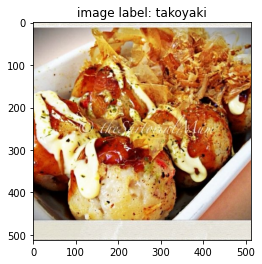

In [17]:
plt.imshow(image)
print(f"image shape: {image.shape}")
plt.title(f"image label: {class_names[label]}")
#plt.axis(False)

need to do a bit of image preprocessing to:
1. resize the image to (224,224)
2. normalizse the image (value between 0 and 1)
3. cast dtype to float32

image size: (224, 224, 3)


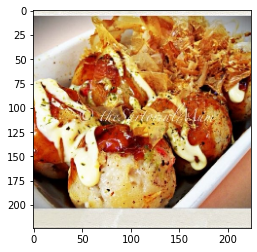

In [18]:
img=tf.image.resize(image,size=[224,224])
print(f"image size: {img.shape}")
plt.imshow(tf.cast(img,dtype=tf.int64))

In [19]:
#let's functonaze this lines of codes for preprocessing an image
def preprocess_image(image, label,image_size=224):
  #resixe the image to (224,224)

  img=tf.image.resize(image,size=[image_size,image_size])
  return tf.cast(img,tf.float32),label


In [20]:
new_image,label=preprocess_image(image,label)

In [21]:
new_image.shape

TensorShape([224, 224, 3])

In [22]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
#let's check which GPU has been allocated by Google Colab
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ac418d57-397b-9ff4-473c-7219a45bd360)


In [25]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
for image,label in train_data.take(1):
  print(f"image shape:{image.shape}")
  print(f"label shape: {label.shape}")


image shape:(32, 224, 224, 3)
label shape: (32,)


see the now the tensors are arranges in batch size (=32) as specifid by the batch command in the tf.Datase. Also the image tensors are in right dtype float32 (but not normalized as we do normalization in the base model of efficientnet.

In [ ]:
image.dtype,image[0][0][0][0]

(tf.float32, <tf.Tensor: shape=(), dtype=float32, numpy=129.0>)

**Some practice on tf.Datasets pipeline** 

In [ ]:
data=np.random.uniform(size=20).reshape(4,5)

In [ ]:
data

array([[0.03415312, 0.0349882 , 0.55949348, 0.44976455, 0.89366762],
       [0.26718863, 0.73001779, 0.30553225, 0.59492355, 0.30426229],
       [0.48575116, 0.92209822, 0.30777301, 0.60457954, 0.33986528],
       [0.37513126, 0.78049672, 0.34218297, 0.64224925, 0.76392623]])

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices(tf.constant(data))

In [ ]:
for item in dataset:
  print(item)

tf.Tensor([0.03415312 0.0349882  0.55949348 0.44976455 0.89366762], shape=(5,), dtype=float64)
tf.Tensor([0.26718863 0.73001779 0.30553225 0.59492355 0.30426229], shape=(5,), dtype=float64)
tf.Tensor([0.48575116 0.92209822 0.30777301 0.60457954 0.33986528], shape=(5,), dtype=float64)
tf.Tensor([0.37513126 0.78049672 0.34218297 0.64224925 0.76392623], shape=(5,), dtype=float64)


In [ ]:
#we can use the take(num) method to get some sample from the dataset
for item in dataset.take(2):
  print(item)

tf.Tensor([0.03415312 0.0349882  0.55949348 0.44976455 0.89366762], shape=(5,), dtype=float64)
tf.Tensor([0.26718863 0.73001779 0.30553225 0.59492355 0.30426229], shape=(5,), dtype=float64)


In [ ]:
for item in dataset.repeat(2):
  print(item)

tf.Tensor([0.03415312 0.0349882  0.55949348 0.44976455 0.89366762], shape=(5,), dtype=float64)
tf.Tensor([0.26718863 0.73001779 0.30553225 0.59492355 0.30426229], shape=(5,), dtype=float64)
tf.Tensor([0.48575116 0.92209822 0.30777301 0.60457954 0.33986528], shape=(5,), dtype=float64)
tf.Tensor([0.37513126 0.78049672 0.34218297 0.64224925 0.76392623], shape=(5,), dtype=float64)
tf.Tensor([0.03415312 0.0349882  0.55949348 0.44976455 0.89366762], shape=(5,), dtype=float64)
tf.Tensor([0.26718863 0.73001779 0.30553225 0.59492355 0.30426229], shape=(5,), dtype=float64)
tf.Tensor([0.48575116 0.92209822 0.30777301 0.60457954 0.33986528], shape=(5,), dtype=float64)
tf.Tensor([0.37513126 0.78049672 0.34218297 0.64224925 0.76392623], shape=(5,), dtype=float64)


In [ ]:
for item in dataset.shuffle(20):
  print(item)

tf.Tensor([0.03415312 0.0349882  0.55949348 0.44976455 0.89366762], shape=(5,), dtype=float64)
tf.Tensor([0.26718863 0.73001779 0.30553225 0.59492355 0.30426229], shape=(5,), dtype=float64)
tf.Tensor([0.48575116 0.92209822 0.30777301 0.60457954 0.33986528], shape=(5,), dtype=float64)
tf.Tensor([0.37513126 0.78049672 0.34218297 0.64224925 0.76392623], shape=(5,), dtype=float64)


In [ ]:
dataset1=dataset.repeat(3).shuffle(10).batch(10)

In [ ]:
for item in dataset1.take(1):
  print(item)

tf.Tensor(
[[0.37513126 0.78049672 0.34218297 0.64224925 0.76392623]
 [0.37513126 0.78049672 0.34218297 0.64224925 0.76392623]
 [0.48575116 0.92209822 0.30777301 0.60457954 0.33986528]
 [0.03415312 0.0349882  0.55949348 0.44976455 0.89366762]
 [0.03415312 0.0349882  0.55949348 0.44976455 0.89366762]
 [0.48575116 0.92209822 0.30777301 0.60457954 0.33986528]
 [0.48575116 0.92209822 0.30777301 0.60457954 0.33986528]
 [0.26718863 0.73001779 0.30553225 0.59492355 0.30426229]
 [0.37513126 0.78049672 0.34218297 0.64224925 0.76392623]
 [0.03415312 0.0349882  0.55949348 0.44976455 0.89366762]], shape=(10, 5), dtype=float64)


In [ ]:
unbatched_dataset1=dataset1.unbatch()

In [ ]:
for item in unbatched_dataset1.take(1):
  print(item)

tf.Tensor([0.37513126 0.78049672 0.34218297 0.64224925 0.76392623], shape=(5,), dtype=float64)


see that this is corresponding to the first entry of the dataset1

In [ ]:
#additional example is when using the map or apply fucntions to da td.dataset

dataset=tf.data.Dataset.from_tensor_slices(tf.range(20))

In [ ]:
for item in dataset.take(3):
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


In [ ]:
new_dataset=dataset.map(lambda x: 2*x)

In [ ]:
for item in new_dataset.take(3):
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


**closed small practice on tf.dataset methods**

In [ ]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
from helper_functions import create_tensorboard_callback

In [ ]:
checkpoint_path="model_checkpoint/cp.ckpt"

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_acc",
                                                    save_best_ony=True,
                                                    save_weight_only=True,
                                                    verbose=1)

In [ ]:
tensorboard_callback=create_tensorboard_callback("/content/Tensorboard","model1")

Saving TensorBoard log files to: /content/Tensorboard/model1/20220816-144811


**important lines of codes ** about **how to set the global mixed precision policy**

In [ ]:
#now need to set up the mixed precision
from tensorflow.keras import mixed_precision

In [ ]:
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
#check which is the global policy setting
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
#let's now build our feature extraction model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
#let's now build our model
input=tf.keras.Input(shape=[224,224,3],name="input_layer")
x=base_model(input,training=False)
x=tf.keras.layers.GlobalAvgPool2D(name="GlobalPool2D")(x)
x=tf.keras.layers.Dense(len(class_names),name="Dense_layer")(x)
#here we are NOT including the activation fucntion in the Denmse layer specification. Mixed precision requires output layer to have dtype float32
output=tf.keras.layers.Activation("softmax",dtype=tf.float32,name="activation_layer")(x)
#note here that we ned to specify the dtype float32 for the Activation layer and this is why we need to separate this from Dense
model=tf.keras.Model(input,output)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalPool2D (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 Dense_layer (Dense)         (None, 101)               129381    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
#let's check which are the trainable layers
len(model.trainable_variables)

2

In [ ]:
for layer in model.layers:
  print(f"layer: {layer.name}, trainable: {layer.trainable}, dtype policy: {layer.dtype_policy}")

layer: input_layer, trainable: True, dtype policy: <Policy "float32">
layer: efficientnetb0, trainable: False, dtype policy: <Policy "mixed_float16">
layer: GlobalPool2D, trainable: True, dtype policy: <Policy "mixed_float16">
layer: Dense_layer, trainable: True, dtype policy: <Policy "mixed_float16">
layer: activation_layer, trainable: True, dtype policy: <Policy "float32">


** see that the last Activation layer is in dtype Float32** while the base model layers are set to float16 due to the mixed precision policy. So this means that tensorfloat calulations are done in float16 while storage and output of data are done in standard float32

In [ ]:
for layer in model.layers[1].layers[-10:]:
  print(f"layer name: {layer.name}, trainable: {layer.trainable}, dtype Policy: {layer.dtype_policy}")

layer name: block7a_se_squeeze, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: block7a_se_reshape, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: block7a_se_reduce, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: block7a_se_expand, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: block7a_se_excite, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: block7a_project_conv, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: block7a_project_bn, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: top_conv, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: top_bn, trainable: False, dtype Policy: <Policy "mixed_float16">
layer name: top_activation, trainable: False, dtype Policy: <Policy "mixed_float16">


In [ ]:
print(model.layers[1].trainable_variables)

[]


so is evident that all the feature extraction layers are frozed and so not trainable

In [ ]:
for image, label in train_data.take(1):
  print(label)

tf.Tensor(
[ 94  55  27  29  29   3  83  69  47  53  83 100  35  29  96  98  82  73
  89  12  86  97  76  35  85  68  19  57  34   4  67  54], shape=(32,), dtype=int64)


labels are in i integers and not hot encoded so we need to use **sparse  categorical cross entropy** for Loss function

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
model_history=model.fit(train_data,epochs=3,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[model_checkpoint,tensorboard_callback])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8224 - accuracy: 0.5567
Epoch 1: saving model to model_checkpoint/cp.ckpt
2368/2368 [==============================] - 223s 86ms/step - loss: 1.8224 - accuracy: 0.5567 - val_loss: 1.2394 - val_accuracy: 0.6777
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2941 - accuracy: 0.6671
Epoch 2: saving model to model_checkpoint/cp.ckpt
2368/2368 [==============================] - 207s 87ms/step - loss: 1.2941 - accuracy: 0.6671 - val_loss: 1.1131 - val_accuracy: 0.7039
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1433 - accuracy: 0.7029
Epoch 3: saving model to model_checkpoint/cp.ckpt
2368/2368 [==============================] - 202s 85ms/step - loss: 1.1433 - accuracy: 0.7029 - val_loss: 1.0922 - val_accuracy: 0.7042


In [ ]:
from helper_functions import plot_loss_curves

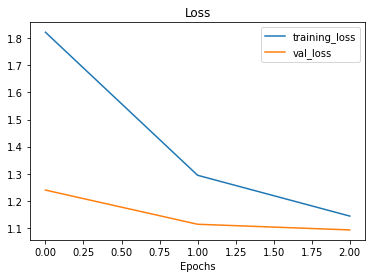

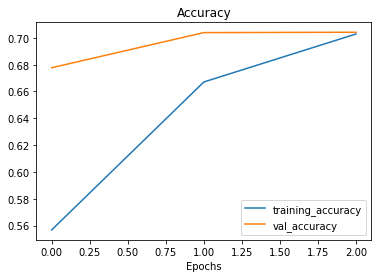

In [ ]:
plot_loss_curves(model_history)

In [ ]:
model_accuracy=model.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.0930 - accuracy: 0.7040


In [ ]:
model.save("/content/drive/MyDrive/Colab/CNN saved models/model_1")

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab/CNN_saved_models")

In [ ]:
model2=tf.keras.models.clone_model(model)

In [ ]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalPool2D (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 Dense_layer (Dense)         (None, 101)               129381    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
model2.load_weights("/content/drive/MyDrive/Colab/CNN_saved_models/model_1")

In [ ]:
model2.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
model2.evaluate(test_data)

790/790 [==============================] - 51s 61ms/step - loss: 1.7191 - accuracy: 0.5482


[1.7191396951675415, 0.5481584072113037]

In [ ]:
model3=tf.keras.models.load_model("/content/saved models/model_1")

In [ ]:
model3.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
model3.evaluate(test_data)

790/790 [==============================] - 53s 62ms/step - loss: 1.0930 - accuracy: 0.7040


[1.0930455923080444, 0.7039999961853027]

**see that this is exactly as the model1 first trained** difrently from the simply model2 where only weights have been loaded

**IMPORTNAT** these are lines of codes to doanload file and directories from google colab

In [ ]:
from google.colab import files

In [ ]:
#download a file
files.download("/content/saved models.index")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#zip all the contect of a folder
!zip -r /content/saved_models.zip /content/saved_models

  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/model_1/ (stored 0%)
  adding: content/saved_models/model_1/keras_metadata.pb (deflated 96%)
  adding: content/saved_models/model_1/saved_model.pb (deflated 91%)
  adding: content/saved_models/model_1/assets/ (stored 0%)
  adding: content/saved_models/model_1/variables/ (stored 0%)
  adding: content/saved_models/model_1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_models/model_1/variables/variables.index (deflated 73%)


In [ ]:
#download the saved model zip file
files.download("/content/saved_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**part 2: play with saved model**

In [27]:
import zipfile

In [28]:
zip_ref=zipfile.ZipFile("/content/models/saved_models.zip",mode="r")
zip_ref.extractall()
zip_ref.close()

In [53]:
model5=tf.keras.models.load_model("/content/content/saved_models/model_1")

In [54]:
model5.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalPool2D (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 Dense_layer (Dense)         (None, 101)               129381    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [55]:
len(model5.trainable_variables)

2

In [56]:
for layer in model5.layers:
  print(f"layer name:{layer.name}, trainable: {layer.trainable}, dtype policy:{layer.dtype_policy}")

layer name:input_layer, trainable: True, dtype policy:<Policy "float32">
layer name:efficientnetb0, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:GlobalPool2D, trainable: True, dtype policy:<Policy "mixed_float16">
layer name:Dense_layer, trainable: True, dtype policy:<Policy "mixed_float16">
layer name:activation_layer, trainable: True, dtype policy:<Policy "float32">


see that I have inherited exactly the model mixed precision dtype policy of original model 1

In [57]:
#let's check the trainable parameters of feature extraction layer
for layer in model5.layers[1].layers[-10:]:   #only last 10 layers
  print(f"layer name:{layer.name}, trainable: {layer.trainable}, dtype policy:{layer.dtype_policy}")

layer name:block7a_se_squeeze, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:block7a_se_reshape, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:block7a_se_reduce, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:block7a_se_expand, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:block7a_se_excite, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:block7a_project_conv, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:block7a_project_bn, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:top_conv, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:top_bn, trainable: False, dtype policy:<Policy "mixed_float16">
layer name:top_activation, trainable: False, dtype policy:<Policy "mixed_float16">


In [58]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [59]:
baseline=model5.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.0930 - accuracy: 0.7040


In [60]:
baseline,len(test_data)

([1.0930465459823608, 0.7039999961853027], 790)

**see that we've got exactly the same result of the original model1**
Now this is the baseline I need to beat using fine tuning

In [61]:
model5.history.history    #note that not having trained the model this variable is empty!

{}

In [65]:
from tensorflow.keras import mixed_precision

In [66]:
!nvidia-smi -L  #OK we have the T4 GPU which is supporting mixed precision operations

GPU 0: Tesla T4 (UUID: GPU-ac418d57-397b-9ff4-473c-7219a45bd360)


In [68]:
mixed_precision.global_policy()

<Policy "float32">

**So we need to reset the mixed precision global policy to float16

In [69]:
mixed_precision.set_global_policy("mixed_float16")

In [70]:
#let's check it again
mixed_precision.global_policy()

<Policy "mixed_float16">

In [71]:
#let's unfroze all the layers including the featire extraction layer
model5.layers[1].trainable=True

In [72]:
len(model5.trainable_variables)

213

In [73]:
from helper_functions import create_tensorboard_callback,plot_loss_curves

In [74]:
earlystop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,min_delta=0.0001)
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("/content/model_checkpoints/cp.ckpt",save_best_only=True,monitor="val_loss")

In [78]:
model5.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(0.0001),metrics=["accuracy"])

In [80]:
model5_history=model5.fit(train_data,epochs=5,initial_epoch=3,steps_per_epoch=len(train_data),
                          validation_data=test_data,validation_steps=int(0.15*len(test_data)),callbacks=[earlystop,model_checkpoint])

Epoch 4/5
2368/2368 [==============================] - 394s 158ms/step - loss: 0.9248 - accuracy: 0.7512 - val_loss: 0.7975 - val_accuracy: 0.7773
Epoch 5/5
2368/2368 [==============================] - 378s 159ms/step - loss: 0.5795 - accuracy: 0.8400 - val_loss: 0.7807 - val_accuracy: 0.7863


In [81]:
model5_history.history

{'loss': [0.924753725528717, 0.5794736742973328],
 'accuracy': [0.7512343525886536, 0.8400396108627319],
 'val_loss': [0.7975492477416992, 0.7806891798973083],
 'val_accuracy': [0.7772775292396545, 0.7862817645072937]}

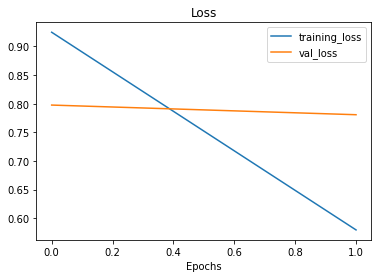

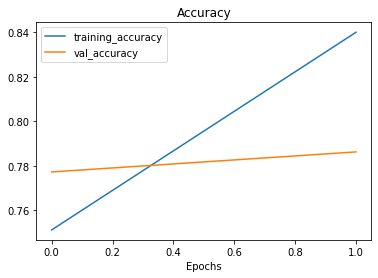

In [82]:
plot_loss_curves(model5_history)

In [83]:
model5.evaluate(test_data)

790/790 [==============================] - 51s 65ms/step - loss: 0.7789 - accuracy: 0.7852


[0.7788840532302856, 0.7852277159690857]

**see that this model5 has beaten model1 (accuracy was 0.7040)** but also the Food101 baseline performance of 0.77 accuracy

In [ ]:
#now let's test model5

In [96]:
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [180]:
image=tf.io.read_file("/content/cannolo.jpg")   #this is an image I've downloaded from internet

In [181]:
image=tf.io.decode_image(image)

In [182]:
new_image=preprocess_image(image,"cannolo")

In [184]:
new_image[0].shape  

TensorShape([224, 224, 3])

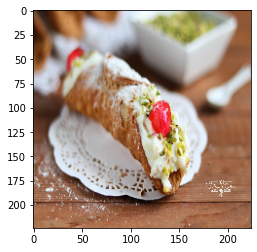

In [186]:
img=tf.cast(new_image[0],dtype=tf.int32)
plt.imshow(img)

In [187]:
#we need to extend the dimension of the image
new_image_tensor=tf.expand_dims(new_image[0],axis=0)
new_image_tensor.shape

TensorShape([1, 224, 224, 3])

In [196]:
new_image[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[120.040855,  77.29241 ,  51.04085 ],
        [106.78058 ,  69.11384 ,  49.49508 ],
        [ 86.19085 ,  62.67968 ,  42.58482 ],
        ...,
        [142.9163  ,  87.083694,  50.069176],
        [144.15265 ,  86.72458 ,  52.903404],
        [145.70961 ,  87.59157 ,  55.72045 ]],

       [[123.19799 ,  78.19799 ,  49.15469 ],
        [115.44312 ,  72.98596 ,  48.47077 ],
        [ 99.21649 ,  67.5469  ,  47.665207],
        ...,
        [146.13281 ,  86.551414,  52.424168],
        [146.07208 ,  86.348175,  52.311188],
        [148.13551 ,  86.52201 ,  53.4209  ]],

       [[131.54353 ,  80.73325 ,  49.54353 ],
        [119.4442  ,  78.13393 ,  49.435238],
        [112.68422 ,  74.41066 ,  52.267853],
        ...,
        [144.69652 ,  85.99671 ,  53.227596],
        [146.02684 ,  86.31593 ,  51.639503],
        [145.23329 ,  88.380554,  54.015743]],

       ...,

       [[193.8926  , 173.02652 , 145.04172 ],
        [173.

In [188]:
pred=model5.predict(new_image_tensor)
pred.shape

(1, 101)

In [189]:
pred=tf.squeeze(pred)
pred.shape

TensorShape([101])

In [190]:
tf.argmax(pred)

<tf.Tensor: shape=(), dtype=int64, numpy=12>

In [191]:
class_names[tf.argmax(pred,axis=0)]

'cannoli'

Let's check othe relevant perfomance indicators

In [124]:
#let's also use other performance metrics
from helper_functions import make_confusion_matrix

In [133]:
(train_data1, test_data1), ds_info=tfds.load(name="food101",split=["train","validation"],as_supervised=True,with_info=True)

In [135]:
train_data1,test_data1

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [137]:
# Map prepreprocessing function to test data
test_data1 = test_data1.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data1 = test_data1.batch(32).prefetch(tf.data.AUTOTUNE)

In [138]:
y_pred=model5.predict(test_data1)

In [139]:
y_pred.shape

(25250, 101)

In [140]:
y_preds=tf.argmax(y_pred,axis=1)
y_preds.shape,y_preds[:10]

(TensorShape([25250]),
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 29,  81,  91,  53,  97,  97,  66,  31,   3, 100])>)

In [142]:
y_true=[]
for image,label in test_data1.unbatch():
  y_true.append(label)
y_true=np.array(y_true)
y_true[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [ ]:
#array([37, 99, 40, 60,  1, 69, 52, 62, 77, 67]) this was the original sequence when we doanloaded the test_data with sfulle_files enables

see that now is really in the right order as I have disabked the shuffle_files option when downaloading the train and test files.  **Is better to shuffle only training data when batching and prefetching**

In [143]:
accuracy=np.mean(y_true==y_preds)
accuracy

0.7852277227722773

**see that now this is exactly the accoracy that we got before**

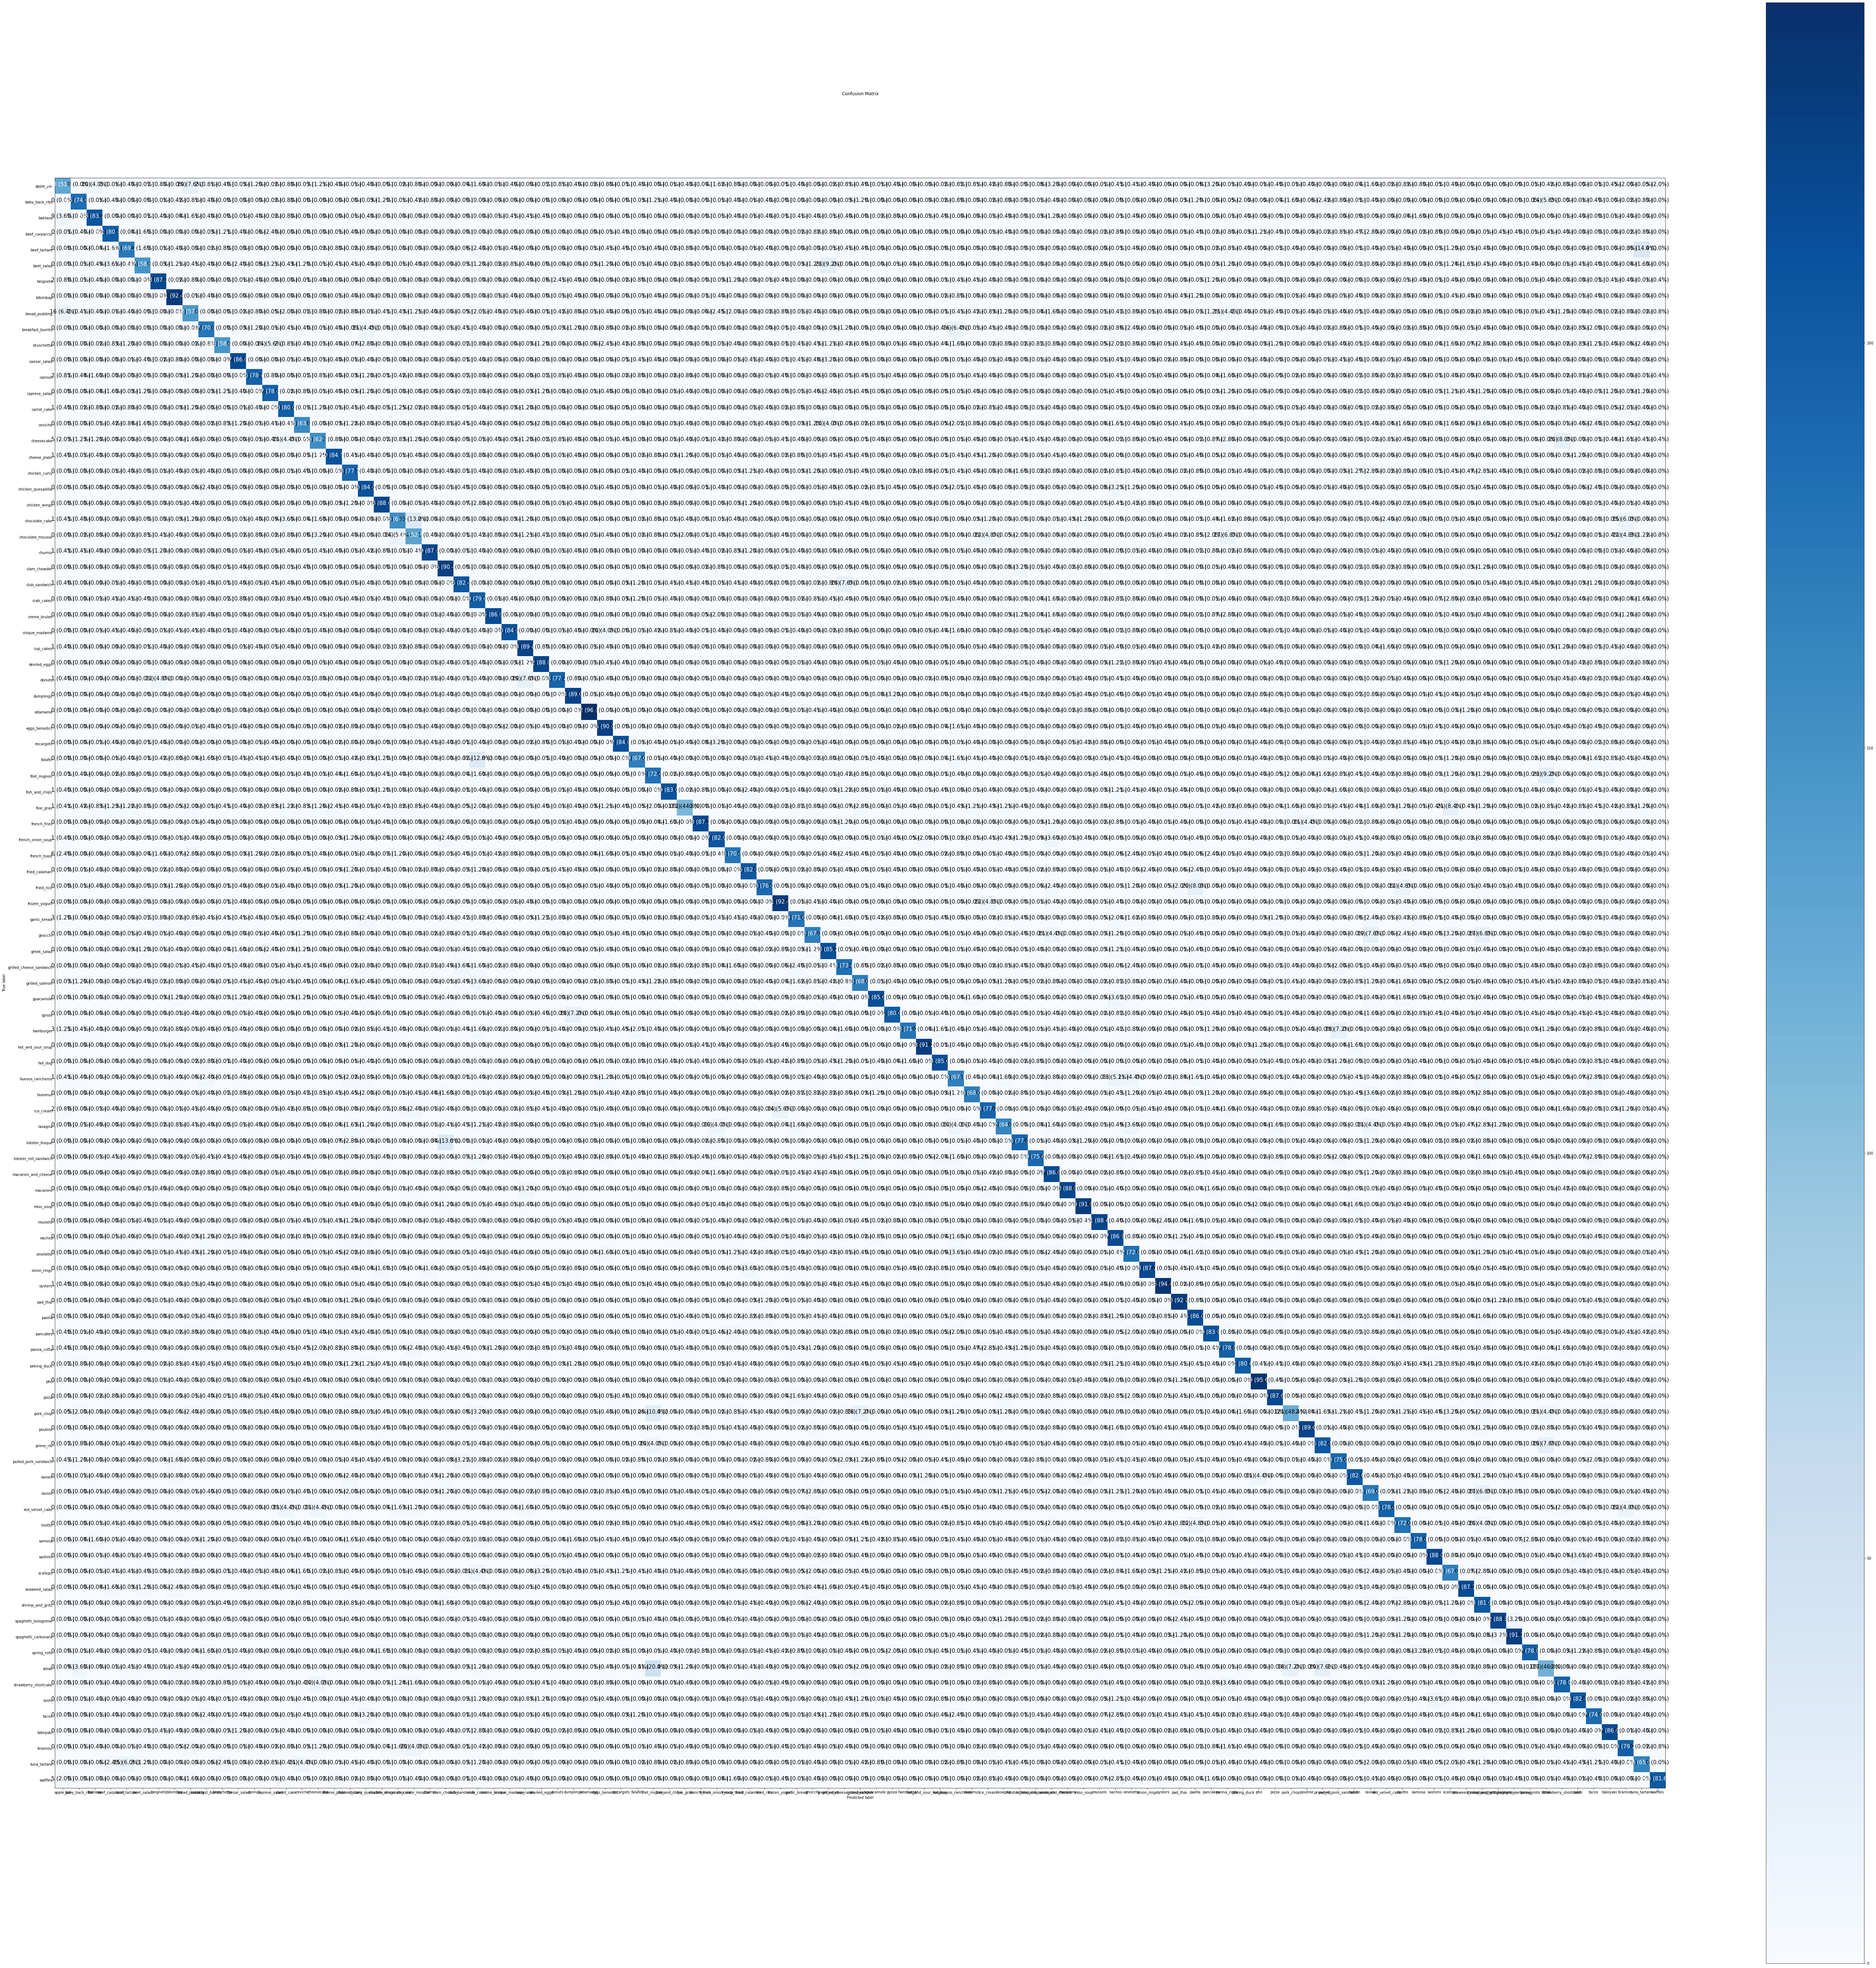

In [146]:
make_confusion_matrix(y_true,y_preds,class_names,figsize=(100,100),norm=True)

In [150]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_preds,target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.65      0.51      0.57       250
         baby_back_ribs       0.84      0.74      0.79       250
                baklava       0.84      0.83      0.83       250
         beef_carpaccio       0.81      0.80      0.81       250
           beef_tartare       0.80      0.69      0.74       250
             beet_salad       0.80      0.59      0.68       250
               beignets       0.88      0.87      0.87       250
               bibimbap       0.81      0.92      0.86       250
          bread_pudding       0.62      0.58      0.60       250
      breakfast_burrito       0.73      0.71      0.72       250
             bruschetta       0.86      0.58      0.70       250
           caesar_salad       0.81      0.87      0.84       250
                cannoli       0.88      0.78      0.83       250
          caprese_salad       0.79      0.79      0.79       250
            carrot_cake 

In [152]:
model5.save("/content/models/model5")

In [154]:
#zip all the contect of a folder
!zip -r /content/models/model5.zip /content/models/model5

updating: content/models/model5/ (stored 0%)
  adding: content/models/model5/keras_metadata.pb (deflated 96%)
  adding: content/models/model5/saved_model.pb (deflated 91%)
  adding: content/models/model5/assets/ (stored 0%)
  adding: content/models/model5/variables/ (stored 0%)
  adding: content/models/model5/variables/variables.index (deflated 78%)
  adding: content/models/model5/variables/variables.data-00000-of-00001 (deflated 8%)


In [155]:
#downloadf the saved model
from google.colab import files

In [156]:
files.download("/content/models/model5.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [157]:
from helper_functions import load_and_prep_image


In [158]:
image=load_and_prep_image("/content/cannolo.jpg")

In [159]:
image.shape

TensorShape([224, 224, 3])

In [201]:
def predict_image(image_path,class_names):

  image=load_and_prep_image(image_path,scale=False)
  extend_image=tf.expand_dims(image,axis=0)
  prediction=model5.predict(extend_image)
  pred=tf.squeeze(prediction)
  return class_names[tf.argmax(pred,axis=0)]




In [202]:
predict_image("/content/cannolo.jpg",class_names)

'cannoli'

In [203]:
predict_image("/content/pasta.jfif",class_names)

'baklava'

In [205]:
"pasta" in class_names

False

In [209]:
predict_image("/content/lasagna2.jfif",class_names)

'garlic_bread'